In [3]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.base.vae import AE
from scvi.distributions import NegativeBinomial

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

In [6]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('allepalma/scCFM_ae_sweep/model-yjw8wquv:v0', type='model')
# artifact_dir = artifact.download()

In [13]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_key': 'experimental_time', 
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [0.8, 0.2],
            'batch_size': 256, 'num_workers': 2}

model_config = {'likelihood': 'nb', 
          'dropout': False, 
          'dropout_p': False, 
          'hidden_dims': [256, 128, 64], 
          'batch_norm': False}

In [14]:
# Initialize datamodule
datamodule = scDataModule(**datamodule)



# Initialize the model 
model = AE(in_dim = datamodule.in_dim,
            **model_config) 

In [16]:
model.load_state_dict(torch.load("/nfs/homedirs/pala/scCFM/notebooks/train_autoencoder/eb/models_ae/model.ckpt")["state_dict"])

<All keys matched successfully>

**Latent space structure**

In [48]:
cells = []
annot = []


with torch.no_grad():
    for batch in datamodule.train_dataloader():
        annot.append(batch["cond"])
        mu = model.encode(batch["X"])["z"]
        cells.append(mu)

In [49]:
cells= torch.cat(cells, dim=0)
annot = pd.DataFrame(torch.cat(annot).numpy())
annot.columns = ["experimental_time"]

In [50]:
adata = sc.AnnData(X=cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [51]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

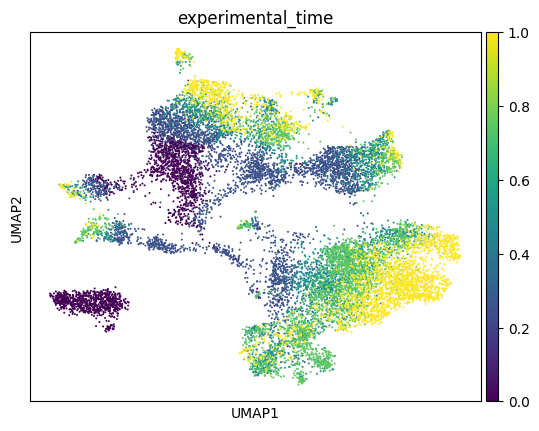

In [52]:
sc.pl.umap(adata, color="experimental_time")

**Generative model from amoritzed**

In [67]:
real_data = [] 
generated_amortized_data = []
annot = []
library_sizes = []

with torch.no_grad():
    for batch in datamodule.train_dataloader():
        real_data.append(batch["X"].numpy())
        annot.append(batch["cond"])
        # Amortized
#         decoder_output = model(batch, library_size=batch["X"].sum(1))
        decoder_output = model(batch, library_size=574)
        nb = NegativeBinomial(mu=decoder_output["mu"], theta=torch.exp(model.theta))
        generated_amortized_data.append(nb.sample())

In [68]:
real_data = np.concatenate(real_data)
generated_amortized_data = np.concatenate(generated_amortized_data)
annot = pd.DataFrame(torch.cat(annot).numpy())
annot.columns = ["experimental_time"]

In [69]:
amortized_and_real = np.concatenate([real_data, generated_amortized_data], axis=0)
dataset_type = ["real" for _ in range(len(real_data))] + ["generated_amortized" for _ in range(len(generated_amortized_data))] 
dataset_type_df = pd.DataFrame(dataset_type)
dataset_type_df.columns = ["dataset_type"]
annot = pd.concat([annot, annot], axis=0).reset_index(drop=True)
annot.columns = ["experimental_time"]

In [70]:
adata_real_amortized = sc.AnnData(X=amortized_and_real, 
                                      obs=pd.concat([dataset_type_df, annot], axis=1))

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [71]:
sc.tl.pca(adata_real_amortized)
sc.pp.neighbors(adata_real_amortized)
sc.tl.umap(adata_real_amortized)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


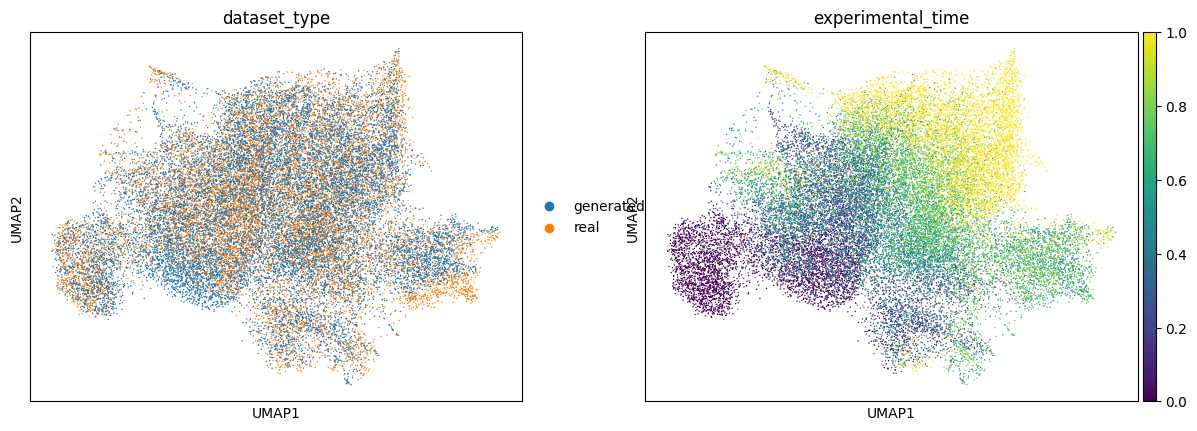

In [72]:
sc.pl.umap(adata_real_amortized, color=["dataset_type", "experimental_time"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


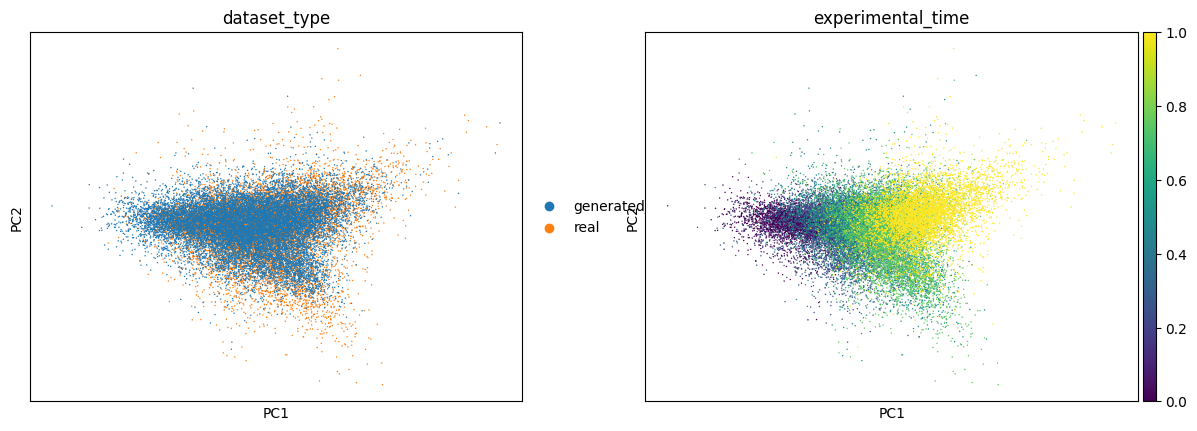

In [73]:
sc.pl.pca(adata_real_amortized, color=["dataset_type", "experimental_time"])